In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-04_13-13_20200101_20200831_lock_periods_by_1.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.002909090909090909

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
YM       0.25
ES       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    12293.2
GC    15468.2
NQ    30163.0
YM    13472.4
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

71396.79999999999

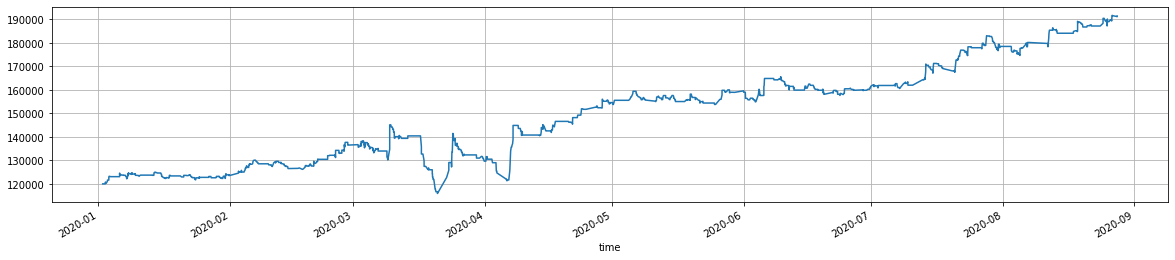

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    159
 GC    290
 NQ    770
 YM    156
 Name: action, dtype: int64,
 1375)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.924419
 GC    1.686047
 NQ    4.476744
 YM    0.906977
 Name: action, dtype: float64,
 7.994186046511628)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     333.9
GC     701.8
NQ    1617.0
YM     327.6
Name: commission, dtype: float64

In [16]:
df.commission.sum()

2980.3

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.43,78.35,817.23,-469.97,1.74,83.53,385.0
GC,0.37,106.68,1206.86,-527.12,2.29,114.45,145.0
YM,0.51,172.72,1159.18,-865.65,1.34,167.01,78.0
ES,0.42,155.61,1559.06,-851.21,1.83,161.10,79.0
total,0.42,103.93,1020.02,-565.26,1.80,100.56,687.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.066399,0.309899,0.636008,0.749742
GC,0.066399,1.000000,-0.132835,0.055229,0.459644
NQ,0.309899,-0.132835,1.000000,0.182352,0.593843
YM,0.636008,0.055229,0.182352,1.000000,0.667326
total,0.749742,0.459644,0.593843,0.667326,1.000000


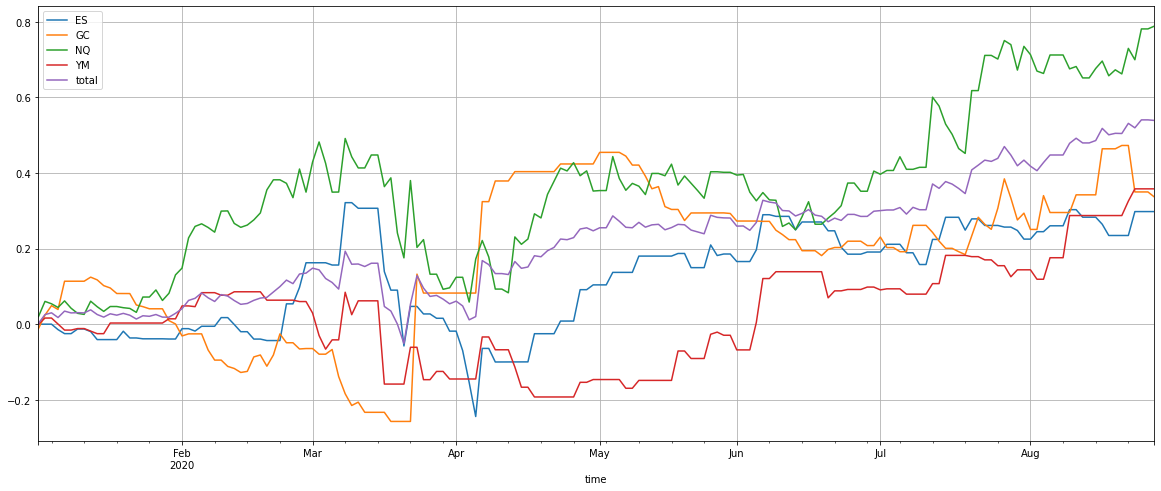

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

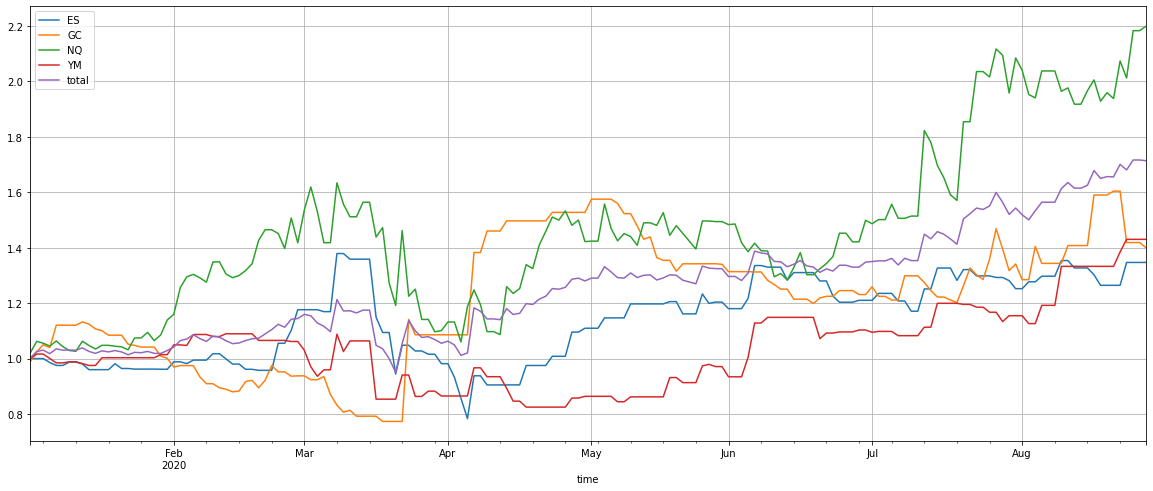

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.546987,0.636418,2.174205,0.689399,1.202181
Cumulative returns,0.346890,0.399559,1.199813,0.430330,0.714000
Annual volatility,0.580598,0.789754,0.809902,0.515965,0.410147
Sharpe ratio,1.034047,0.956530,1.818834,1.275192,2.125346
Calmar ratio,1.266265,2.006147,6.190133,2.838738,5.546505
Stability,0.564721,0.417935,0.660618,0.275555,0.908477
Max drawdown,-0.431969,-0.317234,-0.351237,-0.242854,-0.216746
Omega ratio,1.332948,1.374575,1.424662,1.461849,1.588384
Sortino ratio,1.773306,2.689385,3.265858,2.033438,4.235797
Skew,1.191816,6.053073,1.035180,0.010499,1.873770


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-3.85,0.05,13.93,1.43,2.91
2020-02-29,22.34,-6.29,24.47,4.67,11.22
2020-03-31,-16.55,15.80,-22.36,-18.52,-7.79
2020-04-30,13.02,40.70,29.17,-0.14,21.29
2020-05-31,8.51,-12.27,5.08,12.43,3.44
2020-06-30,0.53,-8.14,0.32,13.59,1.81
2020-07-31,3.47,8.95,39.07,4.67,14.47
2020-08-31,7.56,4.34,5.51,23.88,11.06


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        35.0
GC        40.0
NQ       120.0
YM        43.0
total     71.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-04-07 02:34:00,GC,SELL,1725.00,8205.16
2020-03-24 11:58:30,GC,SELL,1679.70,7985.16
2020-03-23 00:39:30,NQ,BUY,6720.25,6805.80
2020-03-09 14:53:00,ES,BUY,2767.00,6345.80
2020-03-24 06:35:30,GC,SELL,1585.10,6305.16
...,...,...,...,...
2020-04-06 00:00:00,ES,BUY,2504.50,-2579.20
2020-03-17 16:52:00,YM,BUY,20728.00,-2844.20
2020-03-17 02:04:30,YM,BUY,20967.00,-3084.20


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,0.197360,0.273505,0.050387,0.117553,0.159701
2020-03-23,0.110277,0.000000,0.226860,0.102193,0.109833
2020-03-09,0.179303,-0.044495,0.152193,0.134193,0.105299
2020-03-24,0.000000,0.476344,-0.162033,0.000000,0.078578
2020-07-13,0.068610,-0.018495,0.203853,0.028193,0.070541
...,...,...,...,...,...
2020-03-10,0.000000,-0.030495,-0.047227,-0.057640,-0.033840
2020-03-19,0.000000,0.000000,-0.135753,0.000000,-0.033938
2020-04-03,-0.080973,0.000000,-0.063447,0.000000,-0.036105
